In [2]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
sys.path.append(str(parent_dir / "app"))

In [8]:
# Comparing hashes:
json_frontend = '{"amount":10,"receiver":"Ubulkaa","sender":"Ubulka"}'
json_backend = '{"amount":10,"receiver":"Ubulkaa","sender":"Ubulka"}'
assert json_frontend == json_backend, "Difference in JSON strings!"

In [9]:
hash_frontend = 'af99b917da9824e1f38eb6d272322200aba3e66868378d909d8d7fabfb977d43'
hash_backend = 'af99b917da9824e1f38eb6d272322200aba3e66868378d909d8d7fabfb977d43'
assert hash_frontend == hash_backend, "Hash value missmatch!"

In [14]:
from app.blockchain.digital_signature.ecc import ECC, secp256k1

result = secp256k1.scalar_multiply(2, secp256k1.G)
print(result)



(89565891926547004231252920425935692360644145829622209833684329913297188986597, 12158399299693830322967808612713398636155367887041628176798871954788371653930)


In [11]:
r_frontend = '94066448119737183824895799188574515536434840421961608158571727182406170016073'
s_frontend = '59852816966621744259767974194169382177704181177673400000707936230668566544519'
h_frontend = '70302808731685486285597300303522237857654312663970915727068126226860156003620'
r_backend = '94066448119737183824895799188574515536434840421961608158571727182406170016073'
s_backend = '59852816966621744259767974194169382177704181177673400000707936230668566544519'
h_backend = '70302808731685486285597300303522237857654312663970915727068126226860156003620'
assert r_frontend == r_backend, "r missmatch"
assert s_frontend == s_backend, "s missmatch"
assert h_frontend == h_backend, "h missmatch"

# For the talk

In [16]:
# hashing example:
from app.blockchain.hashing.sha2 import SHA256
from Levenshtein import distance as lev
import random
import matplotlib.pyplot as plt

message = "Hello!"
hash = SHA256.digest(message)
hash

'334d016f755cd6dc58c53a86e183882f8ec14f52fb05345887c8a5edd42c87b7'

In [18]:
message2 = "Hello!!"
hash2 = SHA256.digest(message2)
hash2

'bbc7f4c8a2dd11e398bff6829bcb6ed400edbfeb176262b52ca37318da3c5f67'

In [13]:
# Show hash and original distance are uncorrelated:
def random_edit(s):
    i = random.randint(0, len(s)-1)
    c = random.choice('abcdefghijklmnopqrstuvwxyz ')
    op = random.choice(['insert', 'delete', 'substitute'])
    if op == 'insert':
        return s[:i] + c + s[i:]
    elif op == 'delete':
        return s[:i] + s[i+1:]
    else:  # substitute
        return s[:i] + c + s[i+1:]
    
# Generate variants
base = "hello world"
variants = [base]
#print(variants[-1])
for _ in range(50):
    s = random_edit(variants[-1])
    variants.append(s)

# Hash all strings:
hashes = [SHA256.digest(s) for s in variants]

# Compare pairwise distances
x_vals = []
y_vals = []

for i in range(len(variants)):
    for j in range(i+1, len(variants)):
        d_input = lev(variants[i], variants[j])
        d_hash = lev(hashes[i], hashes[j])
        x_vals.append(d_input)
        y_vals.append(d_hash)

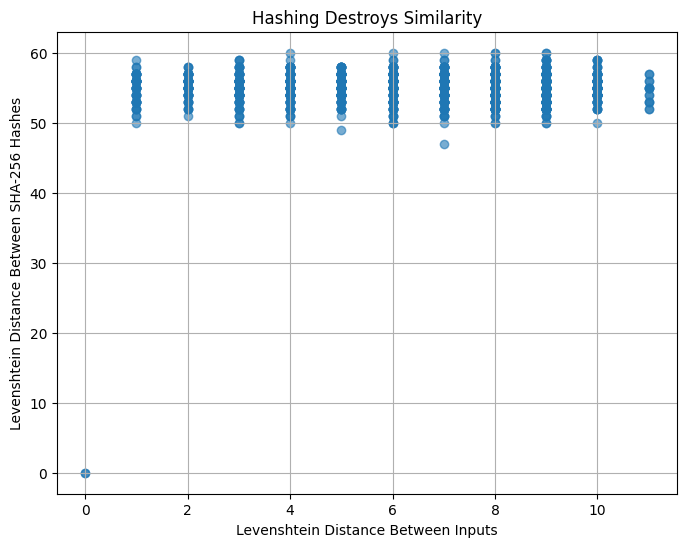

In [ ]:
# Plot the results
plt.figure(figsize=(8,6))
plt.scatter(x_vals, y_vals, alpha=0.6)
plt.xlabel("Levenshtein Distance Between Inputs")
plt.ylabel("Levenshtein Distance Between SHA-256 Hashes")
plt.title("Hashing Destroys Similarity")
plt.grid(True)
#plt.savefig("hashing_levenshtein.png", dpi=300, bbox_inches='tight')
plt.show()

# Server tests

In [2]:
import requests
import random
from app.blockchain.digital_signature.ecc import ECC, secp256k1

server_url = "http://localhost:8000"

### User registration & Login

In [14]:
# Generate a key pair:
def generate_keys(curve: ECC = secp256k1):
    """Generate a new key pair."""
    private_key = random.randint(1, curve.n - 1)
    public_key = curve.scalar_multiply(private_key, curve.G)
    return private_key, public_key

private_key, public_key = generate_keys()

In [15]:
public_key

(34365631488696352424608646959352499352427243731371045968838315980113148767035,
 1966892997176053903764627481088278553924600498686809872848992095167637915989)

In [16]:
# User registration:
user_payload = {
    "username": "testuser",
    "public_key": public_key,
}
user_response = requests.post(f"{server_url}/register", json=user_payload)
user_response.raise_for_status()
print(user_response.json())

{'message': 'User registered successfully', 'username': 'testuser', 'success': 1}


In [17]:
# User login:
user_payload = {
    "username": "testuser",
    "public_key": public_key
}
user_response = requests.post(f"{server_url}/login", json=user_payload)
user_response.raise_for_status()
print(user_response.json())

{'message': 'User logged in successfully', 'username': 'testuser', 'success': 1}


In [18]:
# Adding Ubulka:
u_private, u_public = generate_keys()
user_payload = {
    "username": "Ubulka",
    "public_key": u_public,
}
user_response = requests.post(f"{server_url}/register", json=user_payload)
user_response.raise_for_status()
print(user_response.json())

{'message': 'User registered successfully', 'username': 'Ubulka', 'success': 1}


### Transactions

In [19]:
from app.blockchain.block import Transaction
from app.blockchain.hashing.sha2 import SHA256
import json

transaction = Transaction("testuser", "Ubulka", 100.0) # using the python class for simplicity
transaction.sign(private_key)

transaction_payload = {
    "sender": transaction.sender,
    "receiver": transaction.receiver,
    "amount": str(transaction.amount),
    "signature": transaction.signature
}

In [20]:
tx_data = {
    "sender": transaction.sender,
    "receiver": transaction.receiver,
    "amount": str(transaction.amount),
}
json_data = json.dumps(tx_data, separators=(",", ":"), sort_keys=True)
print(f"Hash string: {json_data}")
print(f"Digest: {SHA256.digest(json_data)}")

Hash string: {"amount":"100.0","receiver":"Ubulka","sender":"testuser"}
Digest: 1b4576825b72cbaa03182ec13f5708fbe548e75c3eefe1394dc7067e09b0a90a


In [25]:
# Submit action:
action_payload = {
    "action_type": "submit_transaction",
    "action_data": transaction_payload
}
action_response = requests.post(f"{server_url}/submit_action", json=action_payload)
action_response.raise_for_status()
print(action_response.json())

{'message': 'Action submitted successfully', 'action_type': 'submit_transaction'}


In [26]:
# Retrieve information:
info_response = requests.get(f"{server_url}/info")
info_response.raise_for_status()
print(info_response.json())

{'users': [{'username': 'testuser', 'public_key': [34365631488696352424608646959352499352427243731371045968838315980113148767035, 1966892997176053903764627481088278553924600498686809872848992095167637915989], 'wallet': 0.0}, {'username': 'Ubulka', 'public_key': [39566148988089044277926638949049978261335782059917795950644664195220629338292, 77124375776201104195794404070539675263683997120341052818345864378492559747909], 'wallet': 0.0}], 'pending_blocks': [{'id': 180651765881548291683580829711433927153, 'num_transactions': 3, 'timestamp': '1743663979.462861', 'finalized': False}], 'pending_transactions': []}


In [28]:
# Get the blockchain:
blockchain_response = requests.get(f"{server_url}/blockchain")
blockchain_response.raise_for_status()
print(blockchain_response.json())

{'blockchain': {'blocks': [{'id': 111, 'previous_hash': '0', 'hash': 'f0af3fd77ae12199b729ff9bf2b74609b07eadf4f89439c21a382384fff3546c', 'timestamp': '1743666527.731102', 'finalized': False, 'nonce': 0, 'transactions': []}]}}


# Digital Signature, Transaction

In [ ]:
from app.blockchain.digital_signature.ecc import secp256k1 # NOTE: There are automated tests for this module
from app.blockchain.block import Transaction
import random

In [3]:
private_key  = random.randint(1, secp256k1.n-1)
public_key = secp256k1.scalar_multiply(private_key, secp256k1.G)
private_key, public_key  

(81887582542687856176065109036894280514370813961086777460981828027979094873831,
 (82656216790249264661209255248079511074180901952758679129451597651865710098962,
  334414800223850064553906847647671735838214391190049804644380619439251544653))

In [4]:
tx = Transaction(sender="Miner Micky", receiver="Miner Moe", amount=100)

In [5]:
tx.hash_transaction()

91469887455764377586877807764597904145762171308828855680586952901254648126450

In [6]:
tx.sign(private_key)
tx.signature

(40399957570093825966803356468860600440685294084868110689532086954465302911264,
 97664644634066426596605947201771500567158417885312160533335701209264856945983)

In [7]:
is_valid = tx.verify(public_key)
is_valid

True

# Block

In [8]:
from src.blockchain.block import Block

In [9]:
tx2 = Transaction(sender="Miner Mike", receiver="Miner Micky", amount=50)
tx3 = Transaction(sender="Miner Mikey", receiver="Miner Micky", amount=60)

our_block = Block(index=0, previous_hash="0", data=[tx, tx2, tx3])

In [10]:
our_block.hash

'b83fa86a7ba0877fa51f44e2780ab3400bf006ecc3348e0f09c37cf9edcbbc39'

In [11]:
our_block.data

In [12]:
def hash_criterion(hash: str):
    return hash.startswith("00")

In [13]:
# PoW
our_block.mine(hash_criterion)

'0047692198739e72807048cccede01262c722f2ab18b3cb01d089385e9f30e0f'

# Blockchain

In [14]:
from src.blockchain.blockchain import Blockchain

In [15]:
our_blockchain = Blockchain(hash_criterion)

In [16]:
# Genesis block:
our_blockchain.chain[0].data

[]

# Network

In [17]:
from src.blockchain.network import Network

In [18]:
our_network = Network(blockchain=our_blockchain)

In [19]:
our_network.add_node("Miner Micky")
our_network.add_node("Miner Moe")
our_network.add_node("Miner Jack")

In [20]:
our_network.nodes

{'Miner Micky': <src.blockchain.node.Node at 0x18c06b972c0>,
 'Miner Moe': <src.blockchain.node.Node at 0x18c06bcad80>,
 'Miner Jack': <src.blockchain.node.Node at 0x18c06bea420>}

In [21]:
our_network.public_keys

{'Miner Micky': (41622633588637395064837534632899103177563255021810681339942519219329431454502,
  11339119106049453601251128794006752414275810446194026569494748432985708591532),
 'Miner Moe': (39404460190203425395014273408697332962575588123573101922508858119537741014037,
  66668214048429706225999017230721584943820025352067835298249834981604891742727),
 'Miner Jack': (104063203318913841572802214968800797595460737852747763654634590208507961887739,
  74392400257205263102671162614944821931143060614409424705746814185051811570221)}

In [22]:
our_network.mine_block_turn_based(block=our_block, max_attempts_per_node=100)

Starting turn-based mining...
Miner Micky is attempting to mine...
Miner Moe is attempting to mine...
Miner Jack is attempting to mine...
No node found a valid block. Restarting round...
Miner Micky is attempting to mine...
Miner Moe is attempting to mine...
Miner Jack is attempting to mine...
No node found a valid block. Restarting round...
Miner Micky is attempting to mine...
Miner Moe is attempting to mine...
Miner Moe successfully mined a block: 00cd72896f7a7a48a0e09e790ab2f3ec94b312b66a6b47965ae6775cc53a3be4
Miner Moe received a mining reward of 10


In [28]:
# Checks
print(f"Blockchain valid: {our_blockchain.validate_chain(our_network.public_keys)}")
print(f"Last added block signed by: {our_blockchain.chain[-1].signed_by}")
print(f"Proof of work direct check: {hash_criterion(our_blockchain.chain[-1].hash)}")
print(f"Is last block finalized: {our_blockchain.chain[-1].finalized}")

Blockchain valid: True
Last added block signed by: Miner Moe
Proof of work direct check: True
Is last block finalized: True


# Hashing

In [ ]:
# NOTE: there are automated tests for this
from src.hashing.sha2 import SHA256

In [25]:
# SHA-256 padding:
sample_message = "kutymutya"
binary_message = SHA256.convert_to_binary_string(sample_message)
binary_message = SHA256.add_padding(binary_message)
blocks = SHA256.split_to_blocks(binary_message)
blocks

['01101011011101010111010001111001011011010111010101110100011110010110000110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001001000']

In [27]:
SHA256.digest("hello") == '2cf24dba5fb0a30e26e83b2ac5b9e29e1b161e5c1fa7425e73043362938b9824'

True